# Disagg gene candidates enrichment

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from networks.functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
#Path for results
pathDisagSigmoid='/home/karin/Documents/timeTrajectories/data/stages/disagg/impulse/filtered/'
pathDisagPCADE='/home/karin/Documents/timeTrajectories/data/stages/disagg/deSeq/'
pathTgrDisVSAX4All='/home/karin/Documents/timeTrajectories/data/stages/disagg/deSeq/disagVSAX4all/'

In [3]:
#Reference
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500),
                                     reference=ALL_GENE_NAMES_EID)
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes & ALL_GENE_NAMES_EID)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size in ref',min_n,'Max size in ref',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size in ref 5 Max size in ref 495
N sets {('KEGG', 'Pathways'): 95, ('GO', 'cellular_component'): 24, ('GO', 'biological_process'): 52, ('GO', 'molecular_function'): 35, ('Custom', 'Baylor'): 15, ('Dictybase', 'Phenotypes'): 207}


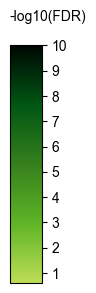

In [4]:
#Result filtering
MAX_FDR_DE=0.01
MIN_ABS_LFC_DE=2
MAX_N_SIGNIFICANT_DE=2
#Enrichment
PADJ=0.25
MIN_OVERLAP=2
#MAX_FE_BAR=80
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#bede57','#5fb526','#36801d','#015713','#000803']

%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=CMAP_FDR_BAR, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)

## Sigmoid models based disag genes
Genes were selected if a more complex model was best fitted in disagg strain compared to WT. Genes were further filtered based on strength of modelled expression changes and starting state in WT vs disag - local min or max of expression (will be described in the Explanations file). 

***  tgrB1 selected: 1547 with EID: 1538
Genes annotated with a gene set in reference 37.8% and group 46.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 427 out of 715 group genes used for enrichment calculation.


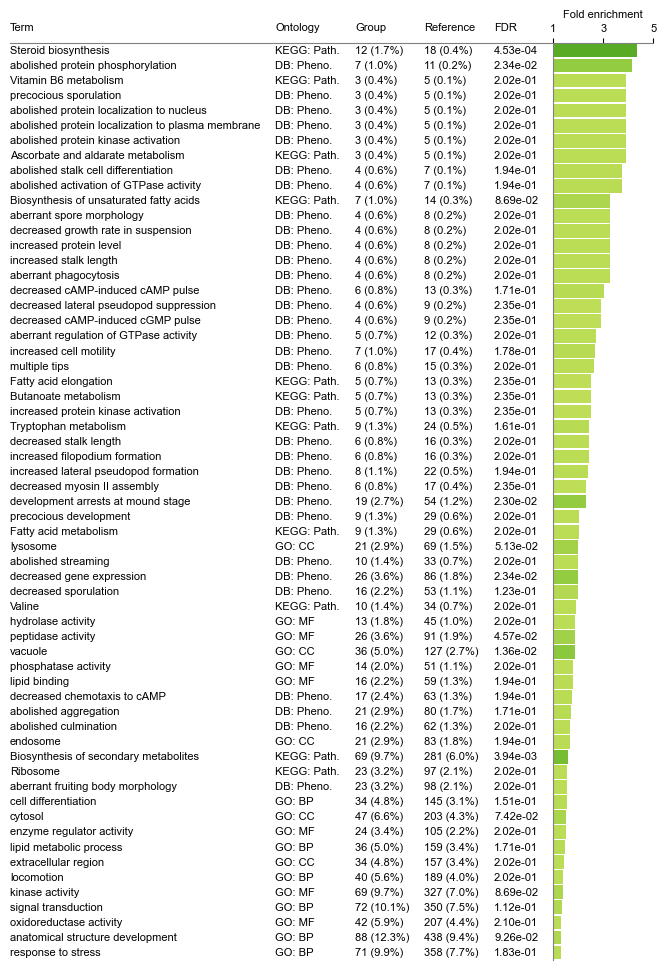

***  tgrB1C1 selected: 1097 with EID: 1089
Genes annotated with a gene set in reference 37.8% and group 47.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 257 out of 512 group genes used for enrichment calculation.


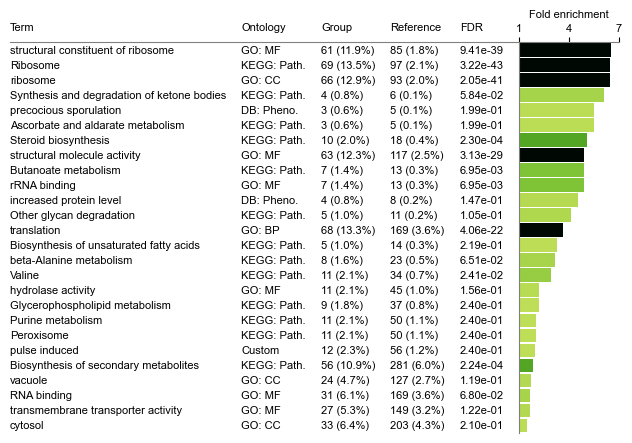

***  tgrC1 selected: 9 with EID: 9
Genes annotated with a gene set in reference 37.8% and group 44.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 2 out of 4 group genes used for enrichment calculation.


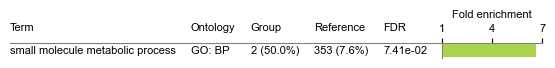

***  gbfA selected: 51 with EID: 51
Genes annotated with a gene set in reference 37.8% and group 51.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 7 out of 26 group genes used for enrichment calculation.


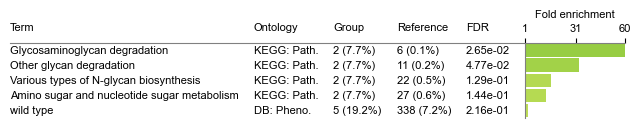

In [5]:
%matplotlib agg
figs=[]
for strain in ['tgrB1','tgrB1C1','tgrC1','gbfA']:
    query_names=pd.read_table(pathDisagSigmoid+'filteredGenes_diffT0.1_'+strain+'.tsv',index_col=0).index
    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=strain,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=None, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    

## PCA DE analysis based genes
Find genes DE between tgrB1 6h and 14h and tgrB1C1 8h and 14h. Use DESeq2 adjusting for replicates. Filter the results with lFC<=-2 or >=2 and padj<=0.01. Earlier timepoint is regarded as the reference in the DE analysis. 

***  tgrB1 log2FoldChange >=2 & padj<=0.01 selected: 1030 with EID: 1022
Genes annotated with a gene set in reference 37.8% and group 41.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 231 out of 417 group genes used for enrichment calculation.


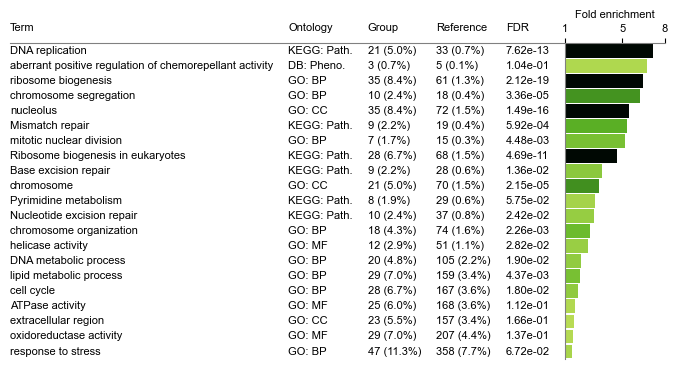

***  tgrB1 log2FoldChange <= -2 & padj<=0.01 selected: 735 with EID: 732
Genes annotated with a gene set in reference 37.8% and group 50.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 232 out of 366 group genes used for enrichment calculation.


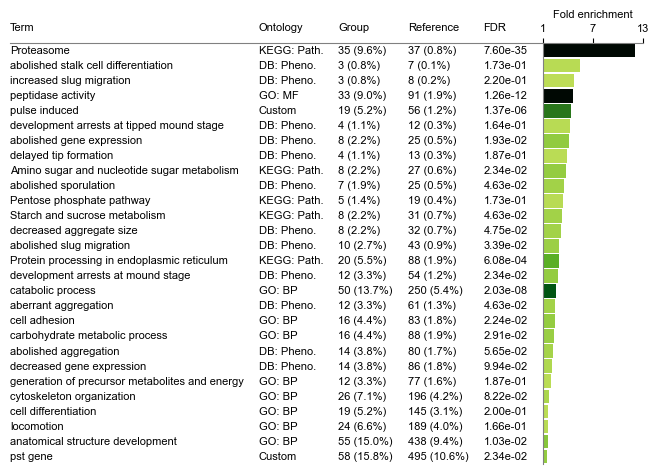

***  tgrB1C1 log2FoldChange >=2 & padj<=0.01 selected: 550 with EID: 546
Genes annotated with a gene set in reference 37.8% and group 40.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 118 out of 220 group genes used for enrichment calculation.


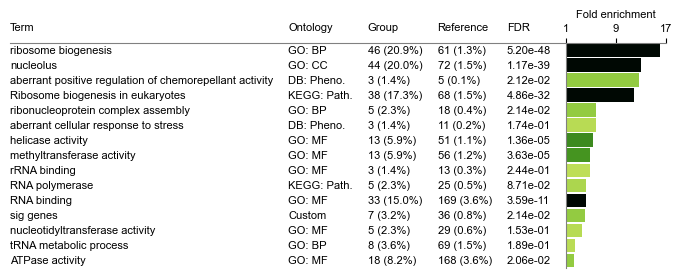

***  tgrB1C1 log2FoldChange <= -2 & padj<=0.01 selected: 159 with EID: 157
Genes annotated with a gene set in reference 37.8% and group 60.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 69 out of 94 group genes used for enrichment calculation.


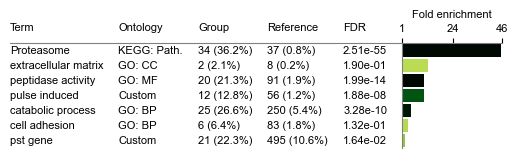

In [31]:
%matplotlib agg
figs=[]
for strain in ['tgrB1','tgrB1C1']:
    for de_filter in ['log2FoldChange >=2 & padj<=0.01','log2FoldChange <= -2 & padj<=0.01']:
        query_data=pd.read_table(pathDisagPCADE+'PCA'+strain+'_DE_dis_ref_agg_padj_lFC.tsv',index_col=0)
        query_names=query_data.query(de_filter).index
        enriched=enr.group_diff_enrichment(query_names=query_names,
                                           group=strain+' '+de_filter,
                                           name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                           gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                           use_annotated_genes=True,
                                           min_overlap=MIN_OVERLAP,padj=PADJ,
                                           make_enrichment_bar=True,
                                           max_FE_bar=None, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                           lFDR_base_bar=LFDR_BASE_BAR
                                          )
        figs.append(enriched[1])
        display(enriched[1][0])
plt.close('all')    

## tgrB1/tgrB1C1 disag vs AX4 all
Genes that are upregulated during tgrB1 and tgrB1C1 disag stage (8,10,12h) compared to all AX4 samples.

***  tgrB1/B1C1 dis vs AX4 all at padj<=0.01 & log2FoldChange >= 2 selected: 103 with EID: 102
Genes annotated with a gene set in reference 37.8% and group 20.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 17 out of 20 group genes used for enrichment calculation.


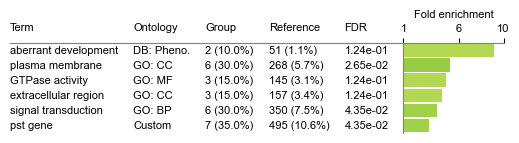

In [9]:
%matplotlib agg
figs=[]
query_data=pd.read_table(
    pathTgrDisVSAX4All+'disagVSAX4all_alternativegreater_FDRoptim0.01DE_tgrB1hr8hr10hr12andtgrB1C1hr8hr10hr12_ref_AX4all_padj_lFC.tsv',
    index_col=0)
filter_value='padj<=0.01 & log2FoldChange >= 2'
query_names=query_data.query(filter_value).index
enriched=enr.group_diff_enrichment(query_names=query_names,
                                   group='tgrB1/B1C1 dis vs AX4 all at '+filter_value,
                                   name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                   gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                   use_annotated_genes=True,
                                   min_overlap=MIN_OVERLAP,padj=PADJ,
                                   make_enrichment_bar=True,
                                   max_FE_bar=None, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                   lFDR_base_bar=LFDR_BASE_BAR
                                  )
figs.append(enriched[1])
display(enriched[1][0])
plt.close('all')    